# Calibration with NN

In [1]:
import numpy as np
import pandas as pd

import torch 
import scipy 
import time

import sys
sys.path.append('../')

# 导入模型
from NN_Training.NN.nn import NN_pricing

# 评估使用 cpu
device = torch.device('cpu')

# 设置参数为 4 个
hyperparams = { 
    'input_dim': 4, 
    'hidden_dim': 64, 
    'hidden_nums': 10,
    'output_dim': 88,
    'block_layer_nums': 3
}

model = NN_pricing(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    '../Data/Models/nn_rBergomi.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (6): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (7): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (8): Sequential(
      (0): Linear(in_feat

## 数据

In [2]:
# 数据集
import gzip
f = gzip.GzipFile(
    filename = r"../Data/rBergomiTrainSet.txt.gz", 
    mode = "r"
)

data = np.load(f)
xx, yy = data[:, :4], data[:, 4:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# xx: 参数
## 前 4 列代表网格所对应的参数
xx = data[:, :4]
print(f"参数形状：{xx.shape}")

# yy: 隐含波动率曲面 
# 后 88 列表示隐含波动率曲面 8 * 11 = 88
yy = data[:, 4:]
print(f"隐含波动率曲面形状：{yy.shape}")

# 参数
print(f"参数上界: {np.max(xx, axis=0)}")
print(f"参数下界: {np.min(xx, axis=0)}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')

# from NN_Training.rBergomi_nn_pricer import x_transform, x_inv_transform, y_transform, y_inv_transform, params_scaler, params_inv_scaler


x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.15, random_state=42)

scale_x, scale_y = StandardScaler(), StandardScaler()


# 工具函数——数据标准化
def x_transform(train_data, test_data): 
    return scale_x.fit_transform(train_data), scale_x.transform(test_data)

def x_inv_transform(x):
    return scale_x.inverse_transform(x)

def y_transform(train_data, test_data): 
    return scale_y.fit_transform(train_data), scale_y.transform(test_data)

def y_inv_transform(y):
    return scale_y.inverse_transform(y)


# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

def params_scaler(x): 
    return (x - (upper_bound+lower_bound) / 2 ) * 2 / (upper_bound-lower_bound)

def params_inv_scaler(x):
    return x * (upper_bound-lower_bound) / 2 + (upper_bound+lower_bound) / 2


x_train_transform = params_scaler(x_train)
x_test_transform = params_scaler(x_test)

y_train_transform, y_test_transform = y_transform(y_train, y_test)


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))

test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))


print(f"训练集形状：{train_data[0].shape}")
print(f"测试集形状：{test_data[0].shape}")

参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]
训练集形状：torch.Size([34000, 4])
测试集形状：torch.Size([6000, 4])


## 校准优化

In [3]:
import torch.nn as nn

loss_MSE = nn.MSELoss()

vol_model = y_inv_transform(model(test_data[0]).detach().numpy())
vol_real = y_test

error_real = np.abs(vol_model-vol_real)
error_relative = error_real/vol_real

np.mean(error_relative)


# 使用 LBFGS 优化器
from optimization_utils import calibrate_with_torch_lbfgs

Approx, Timing = calibrate_with_torch_lbfgs(model, y_test_transform, device='cpu')


print(f"LBFGS 优化结果 (前 10 个): {Approx[:10]}")
print(f"LBFGS 优化时间 (前 10 个): {Timing[:10]}")

LBFGS 优化结果 (前 10 个): [[ 0.2718526  -0.84177326 -0.44196364 -0.11724242]
 [ 0.92646886  0.63670469  0.14527745  0.1025588 ]
 [ 0.10138511 -0.08402274 -0.21554354 -0.49044345]
 [-0.68391753 -0.53723164 -0.16574831 -0.1774751 ]
 [-0.12698649 -0.8060794   0.39369799 -0.64026452]
 [-0.77693773  0.65927194 -0.4914505  -0.37049258]
 [ 0.95820271  0.64735446  0.09682647 -0.02687364]
 [-0.11308724  0.16684554 -0.53941525  0.01480419]
 [-0.95194173  0.5748682   0.16220536  0.19815356]
 [-0.30674038 -0.92243137  0.86765812 -0.1464441 ]]
LBFGS 优化时间 (前 10 个): [0.22574258 0.1875999  0.1952157  0.21575189 0.21120024 0.19905877
 0.17989588 0.19130325 0.1920712  0.21114159]


## 可视化

Text(0.5, 1.05, 'Torch L-BFGS Calibration Error')

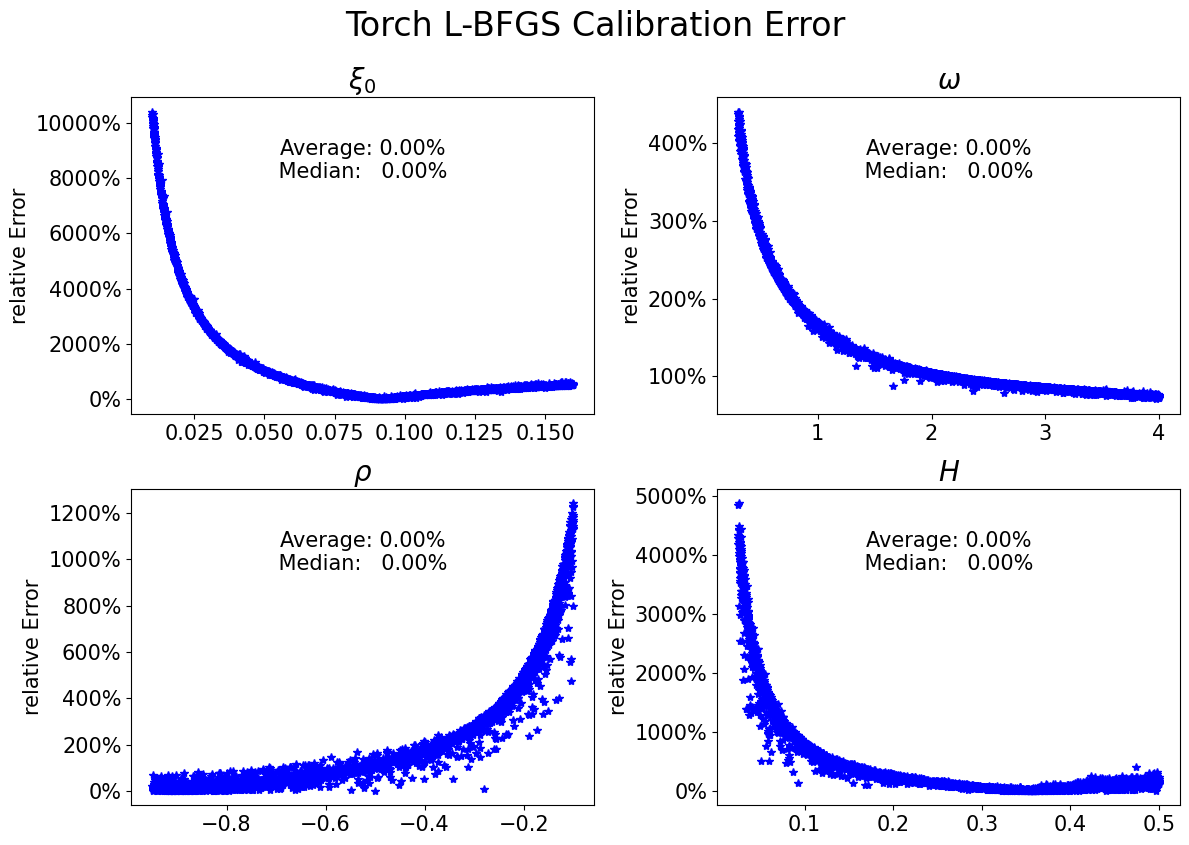

In [11]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

titles = ["$\\xi_0$","$\\omega$","$\\rho$","$H$"]

average = np.zeros([4,6000])
fig = plt.figure(figsize=(12,8))
for u in range(4): 
    ax = plt.subplot(2, 2, u+1)
    x = x_test[:6000, u]
    plt.plot( 
        x, 
        100 * np.abs( Approx[:6000, u] - x ) / np.abs(x), 
        'b*'
    )

    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
plt.suptitle("Torch L-BFGS Calibration Error", fontsize=24, y=1.05)